### 트랜스포머를 활용한 챗봇 알고리즘

#### 데이콘에서 제공하는 대회 데이터 활용
#####  - 대회명 : '도배 하자 질의 응답 처리 : 한솔데코 시즌2 AI 경진대회'
#####  - URL : https://dacon.io/competitions/official/236216/data

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Layer
import matplotlib.pyplot as plt
import numpy as np
import pydot

In [2]:
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)

    # 배열의 짝수 인덱스(2i)에는 사인 함수 적용
        sines = tf.math.sin(angle_rads[:, 0::2])

    # 배열의 홀수 인덱스(2i+1)에는 코사인 함수 적용
        cosines = tf.math.cos(angle_rads[:, 1::2])

        angle_rads = np.zeros(angle_rads.shape)
        angle_rads[:, 0::2] = sines
        angle_rads[:, 1::2] = cosines
        pos_encoding = tf.constant(angle_rads)
        pos_encoding = pos_encoding[tf.newaxis, ...]

        print(pos_encoding.shape)
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]


In [4]:
def scaled_dot_product_attention(query, key, value, mask):
  # query 크기 : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
  # key 크기 : (batch_size, num_heads, key의 문장 길이, d_model/num_heads)
  # value 크기 : (batch_size, num_heads, value의 문장 길이, d_model/num_heads)
  # padding_mask : (batch_size, 1, 1, key의 문장 길이)

  # Q와 K의 곱. 어텐션 스코어 행렬.
    matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 스케일링
  # dk의 루트값으로 나눠준다.
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

  # 마스킹. 어텐션 스코어 행렬의 마스킹 할 위치에 매우 작은 음수값을 넣는다.
  # 매우 작은 값이므로 소프트맥스 함수를 지나면 행렬의 해당 위치의 값은 0이 된다.
    if mask is not None:
        logits += (mask * -1e9)

  # 소프트맥스 함수는 마지막 차원인 key의 문장 길이 방향으로 수행된다.
  # attention weight : (batch_size, num_heads, query의 문장 길이, key의 문장 길이)
    attention_weights = tf.nn.softmax(logits, axis=-1)

  # output : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
    output = tf.matmul(attention_weights, value)

    return output, attention_weights


In [5]:
# 임의의 Query, Key, Value인 Q, K, V 행렬 생성
np.set_printoptions(suppress=True)
temp_k = tf.constant([[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[   1,0],
                      [  10,0],
                      [ 100,5],
                      [1000,6]], dtype=tf.float32)  # (4, 2)
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)


In [6]:
# 함수 실행
temp_out, temp_attn = scaled_dot_product_attention(temp_q, temp_k, temp_v, None)
print(temp_attn) # 어텐션 분포(어텐션 가중치의 나열)
print(temp_out) # 어텐션 값


tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


In [7]:
temp_q = tf.constant([[0, 0, 10]], dtype=tf.float32)
temp_out, temp_attn = scaled_dot_product_attention(temp_q, temp_k, temp_v, None)
print(temp_attn) # 어텐션 분포(어텐션 가중치의 나열)
print(temp_out) # 어텐션 값


tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)
tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)


In [8]:
class MultiHeadAttention(tf.keras.layers.Layer):

    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

    # d_model을 num_heads로 나눈 값.
    # 논문 기준 : 64
        self.depth = d_model // self.num_heads

    # WQ, WK, WV에 해당하는 밀집층 정의
        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

    # WO에 해당하는 밀집층 정의
        self.dense = tf.keras.layers.Dense(units=d_model)

  # num_heads 개수만큼 q, k, v를 split하는 함수
    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs['value'], inputs['mask']
        batch_size = tf.shape(query)[0]

    # 1. WQ, WK, WV에 해당하는 밀집층 지나기
    # q : (batch_size, query의 문장 길이, d_model)
    # k : (batch_size, key의 문장 길이, d_model)
    # v : (batch_size, value의 문장 길이, d_model)
    # 참고) 인코더(k, v)-디코더(q) 어텐션에서는 query 길이와 key, value의 길이는 다를 수 있다.
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

    # 2. 헤드 나누기
    # q : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
    # k : (batch_size, num_heads, key의 문장 길이, d_model/num_heads)
    # v : (batch_size, num_heads, value의 문장 길이, d_model/num_heads)
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

    # 3. 스케일드 닷 프로덕트 어텐션. 앞서 구현한 함수 사용.
    # (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
        scaled_attention, _ = scaled_dot_product_attention(query, key, value, mask)
    # (batch_size, query의 문장 길이, num_heads, d_model/num_heads)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 4. 헤드 연결(concatenate)하기
    # (batch_size, query의 문장 길이, d_model)
        concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 5. WO에 해당하는 밀집층 지나기
    # (batch_size, query의 문장 길이, d_model)
        outputs = self.dense(concat_attention)

        return outputs


In [9]:
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, key의 문장 길이)
    return mask[:, tf.newaxis, tf.newaxis, :]


In [10]:
print(create_padding_mask(tf.constant([[1, 21, 777, 0, 0]])))


tf.Tensor([[[[0. 0. 0. 1. 1.]]]], shape=(1, 1, 1, 5), dtype=float32)


In [11]:
def encoder_layer(dff, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 인코더는 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 멀티-헤드 어텐션 (첫번째 서브층 / 셀프 어텐션)
    attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs, 'key': inputs, 'value': inputs, # Q = K = V
          'mask': padding_mask # 패딩 마스크 사용
      })

  # 드롭아웃 + 잔차 연결과 층 정규화
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 포지션 와이즈 피드 포워드 신경망 (두번째 서브층)
    outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 드롭아웃 + 잔차 연결과 층 정규화
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)


In [12]:
def encoder(vocab_size, num_layers, dff,
            d_model, num_heads, dropout,
            name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 인코더는 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 포지셔널 인코딩 + 드롭아웃
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # 인코더를 num_layers개 쌓기
    for i in range(num_layers):
        outputs = encoder_layer(dff=dff, d_model=d_model, num_heads=num_heads,
        dropout=dropout, name="encoder_layer_{}".format(i),)([outputs, padding_mask])

    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)


In [13]:
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    # 행렬의 대각선 밴드(위에서 아래로) 기준으로 하부삼각행렬과 상부삼각행렬로 나누어
    # 하부삼각행렬 -1 은 전부 포함
    # 상부삼각행렬 0은 포함하지 않음(상부삼각행렬은 입력단어 이후에 등장하는 단어벡터로 마스킹해야 함)
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x) # 패딩 마스크도 포함
    return tf.maximum(look_ahead_mask, padding_mask)

In [14]:
print(create_look_ahead_mask(tf.constant([[1, 2, 0, 4, 5]])))


tf.Tensor(
[[[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 0. 1.]
   [0. 0. 1. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


In [15]:
def decoder_layer(dff, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")

  # 룩어헤드 마스크(첫번째 서브층)
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="look_ahead_mask")

  # 패딩 마스크(두번째 서브층)
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 멀티-헤드 어텐션 (첫번째 서브층 / 마스크드 셀프 어텐션)
    attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs, 'key': inputs, 'value': inputs, # Q = K = V
          'mask': look_ahead_mask # 룩어헤드 마스크
      })

  # 잔차 연결과 층 정규화
    attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 멀티-헤드 어텐션 (두번째 서브층 / 디코더-인코더 어텐션)
    attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1, 'key': enc_outputs, 'value': enc_outputs, # Q != K = V
          'mask': padding_mask # 패딩 마스크
      })

  # 드롭아웃 + 잔차 연결과 층 정규화
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 포지션 와이즈 피드 포워드 신경망 (세번째 서브층)
    outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 드롭아웃 + 잔차 연결과 층 정규화
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

    return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)


In [16]:
def decoder(vocab_size, num_layers, dff,
            d_model, num_heads, dropout,
            name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')

  # 디코더는 룩어헤드 마스크(첫번째 서브층)와 패딩 마스크(두번째 서브층) 둘 다 사용.
    look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 포지셔널 인코딩 + 드롭아웃
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # 디코더를 num_layers개 쌓기
    for i in range(num_layers):
        outputs = decoder_layer(dff=dff, d_model=d_model, num_heads=num_heads,
        dropout=dropout, name='decoder_layer_{}'.format(i),)(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)


In [17]:
def transformer(vocab_size, num_layers, dff,
                d_model, num_heads, dropout,
                name="transformer"):

  # 인코더의 입력
    inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 디코더의 입력
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더의 패딩 마스크
    enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더의 룩어헤드 마스크(첫번째 서브층)
    look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask, output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 디코더의 패딩 마스크(두번째 서브층)
    dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더의 출력은 enc_outputs. 디코더로 전달된다.
    enc_outputs = encoder(vocab_size=vocab_size, num_layers=num_layers, dff=dff,
      d_model=d_model, num_heads=num_heads, dropout=dropout,
  )(inputs=[inputs, enc_padding_mask]) # 인코더의 입력은 입력 문장과 패딩 마스크

  # 디코더의 출력은 dec_outputs. 출력층으로 전달된다.
    dec_outputs = decoder(vocab_size=vocab_size, num_layers=num_layers, dff=dff,
      d_model=d_model, num_heads=num_heads, dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 다음 단어 예측을 위한 출력층
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)


In [18]:
small_transformer = transformer(
    vocab_size = 9000,
    num_layers = 4,
    dff = 512,
    d_model = 128,
    num_heads = 4,
    dropout = 0.3,
    name="small_transformer")

tf.keras.utils.plot_model(
    small_transformer, to_file='small_transformer.png', show_shapes=True)


(1, 9000, 128)
(1, 9000, 128)
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [19]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

    loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)


In [20]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        step = tf.cast(step, tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)


Text(0.5, 0, 'Train Step')

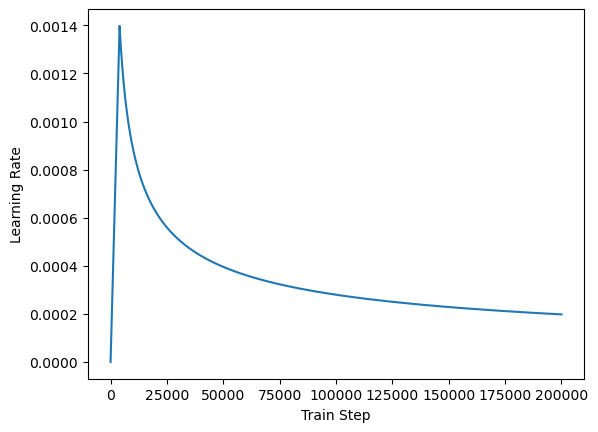

In [21]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
import time
import tensorflow_datasets as tfds
import tensorflow as tf

In [23]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [27]:
train_data = pd.read_csv('./llm_qna/data/train.csv')
train_data.head()

,id,질문_1,질문_2,category,답변_1,답변_2,답변_3,답변_4,답변_5
0,TRAIN_000,면진장치가 뭐야?,면진장치에 사용되는 주요 기술은 무엇인가요?,건축구조,면진장치란 지반에서 오는 진동 에너지를 흡수하여 건물에 주는 진동을 줄여주는 진동 ...,"면진장치란 건물의 지반에서 발생하는 진동 에너지를 흡수하여 건물을 보호하고, 진동을...",면진장치란 지반으로부터 발생하는 진동 에너지를 흡수하여 건물에 전달되는 진동을 줄여...,면진장치는 건물의 지반으로부터 오는 진동 에너지를 흡수하여 건물에 전달되는 진동을 ...,면진장치는 건물에 오는 지반 진동의 영향을 최대한으로 흡수하여 건물에 전달되는 진동...
1,TRAIN_001,내진설계의 종류 좀 알려줘,내진설계에는 어떤 종류가 있는지 자세히 알려주실 수 있나요?,건축구조,"내진 설계의 종류로 내진구조, 제진구조, 면진구조가 있습니다.","내진설계에는 내진구조, 제진구조, 면진구조가 있습니다. 내진구조는 건물 구조물이 지...","내진설계에는 주로 내진구조, 제진구조, 면진구조의 세 가지 종류가 있습니다. 이들은...","내진설계에는 주로 내진구조, 제진구조, 면진구조가 사용됩니다. 내진구조는 건물 구조...","내진 설계에는 다양한 종류가 있지만, 대표적으로 내진구조, 제진구조, 면진구조가 있..."
2,TRAIN_002,철골구조의 장점이 뭐야?,철골구조의 장점을 알려줘?,건축구조,철골구조는 건물의 외벽에는 그다지 하중이 걸리지 않기 때문에 고층 건물의 건축이 가...,철골구조의 장점은 건물의 외벽에는 그다지 하중이 걸리지 않기 때문에 고층 건물의 건...,철골구조의 장점은 건물의 외벽에 하중이 적게 걸리기 때문에 고층 건물의 건축이 용이...,"철골구조의 장점은 건물의 외벽이 하중이 걸리지 않아 공간 활용이 용이하고, 고층 건...",철골구조의 장점은 건물의 외벽에 하중이 크게 걸리지 않아 고층 건물을 건축할 수 있...
3,TRAIN_003,철골철근 콘크리트 구조가 뭐야?,철골철근 콘크리트 구조의 장점과 단점에는 무엇이 있을까요?,건축구조,"철근철골콘크리트는 철골과 철근, 그리고 콘크리트를 함께 사용하는 건축 구조입니다. ...","철골철근콘크리트 구조는 건축물을 지탱하는 주요 구조물인 철골과 철근, 그리고 콘크리...",철골철근 콘크리트 구조는 건축물을 지탱하기 위한 구조물에서 일반적으로 사용되는 방식...,"철골철근콘크리트 구조는 철골과 철근, 그리고 콘크리트를 함께 사용하여 만들어지는 건...","철골철근 콘크리트 구조는 강철 골조와 강철 철근, 그리고 콘크리트를 함께 사용하여 ..."
4,TRAIN_004,철골구조는 어떤 방식이 있어?,철골구조의 다양한 방식이 무엇인가요?,건축구조,철골구조는 일반철골구조와 경량철골구조가 있습니다.,철골구조는 일반철골구조와 경량철골구조가 있습니다. 일반철골구조는 주로 대형 건물이나...,철골구조는 주로 일반철골구조와 경량철골구조로 나뉘어집니다. 이들은 건축 시스템에 따...,철골구조는 주로 일반철골구조와 경량철골구조로 구분됩니다. 이외에도 최근에는 고층 건...,철골구조는 일반철골구조와 경량철골구조 두 가지 방식이 주로 사용됩니다. 일반철골구조...


In [28]:
print(train_data.isnull().sum())

id          0
질문_1        0
질문_2        0
category    0
답변_1        0
답변_2        0
답변_3        0
답변_4        0
답변_5        0
dtype: int64


In [29]:
train_data.shape

(644, 9)

In [35]:
questions = []

for i in range(5):
    for sentence in train_data['질문_1']:
        sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
        sentence = sentence.strip()
        questions.append(sentence)

In [36]:
len(questions)

3220

In [37]:
for i in range(5):
    for sentence in train_data['질문_2']:
        sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
        sentence = sentence.strip()
        questions.append(sentence)

In [38]:
len(questions)

6440

In [40]:
questions[3220]

'면진장치에 사용되는 주요 기술은 무엇인가요 ?'

In [43]:
answers = []

for i in range(2):
    
    for sentence in train_data['답변_1']:
        sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
        sentence = sentence.strip()
        answers.append(sentence)
        
    for sentence in train_data['답변_2']:
        sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
        sentence = sentence.strip()
        answers.append(sentence)
        
    for sentence in train_data['답변_3']:
        sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
        sentence = sentence.strip()
        answers.append(sentence)
        
    for sentence in train_data['답변_4']:
        sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
        sentence = sentence.strip()
        answers.append(sentence)
        
    for sentence in train_data['답변_5']:
        sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
        sentence = sentence.strip()
        answers.append(sentence)

In [44]:
len(answers)

6440

In [45]:
print(questions[:5])
print(answers[:5])

['면진장치가 뭐야 ?', '내진설계의 종류 좀 알려줘', '철골구조의 장점이 뭐야 ?', '철골철근 콘크리트 구조가 뭐야 ?', '철골구조는 어떤 방식이 있어 ?']
['면진장치란 지반에서 오는 진동 에너지를 흡수하여 건물에 주는 진동을 줄여주는 진동 격리장치입니다 .', '내진 설계의 종류로 내진구조 ,  제진구조 ,  면진구조가 있습니다 .', '철골구조는 건물의 외벽에는 그다지 하중이 걸리지 않기 때문에 고층 건물의 건축이 가능한 것이 장점입니다 .', '철근철골콘크리트는 철골과 철근 ,  그리고 콘크리트를 함께 사용하는 건축 구조입니다 .  철골은 강하고 가벼운 소재로 ,  높은 내구성과 강도를 가지고 있어 대규모 공간이나 강성이 요구되는 대형 고층건물에 적합합니다 .  그러나 화재에 취약하고 녹이 슬면 강성이 떨어지는 단점이 있습니다 .  이를 보완하기 위해 철근과 콘크리트를 섞어 사용하는 방식이 개발되었습니다 .  철근콘크리트는 철근이 인장력을 ,  콘크리트가 압축력을 담당하여 강성을 가지며 콘크리트의 열전도가 낮은 재료상 특징을 이용해 서로의 단점을 보완하도록 결합한 구조입니다 .  내화성 ,  내구성 ,  내진성능이 뛰어나지만 자중이 크고 시공과정이 복잡하며 공사기간이 길고 균일한 시공이 불가능하다는 단점이 있습니다 .  철근철골콘크리트는 이 두 가지 구조의 장점을 살려 만든 것으로 ,  철골 뼈대로 구조를 세우고 그 주변을 철근과 콘크리트로 감싸거나 ,  철근과 콘크리트로 구조를 만들고 그 위에 철골을 올리는 형태로 만들어집니다 .  이렇게 함으로써 철골의 내구성과 강도를 높이면서도 화재에 대한 안전성을 높일 수 있습니다 .', '철골구조는 일반철골구조와 경량철골구조가 있습니다 .']


In [46]:
# 서브워드텍스트인코더를 사용하여 질문, 답변 데이터로부터 단어 집합(Vocabulary) 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    questions + answers, target_vocab_size=2**13)

In [47]:
# 시작 토큰과 종료 토큰에 대한 정수 부여.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

# 시작 토큰과 종료 토큰을 고려하여 단어 집합의 크기를 + 2
VOCAB_SIZE = tokenizer.vocab_size + 2

In [48]:
print('시작 토큰 번호 :',START_TOKEN)
print('종료 토큰 번호 :',END_TOKEN)
print('단어 집합의 크기 :',VOCAB_SIZE)

시작 토큰 번호 : [8537]
종료 토큰 번호 : [8538]
단어 집합의 크기 : 8539


In [49]:
# 서브워드텍스트인코더 토크나이저의 .encode()를 사용하여 텍스트 시퀀스를 정수 시퀀스로 변환
print('임의의 질문 샘플을 정수 인코딩 : {}'.format(tokenizer.encode(questions[20])))

임의의 질문 샘플을 정수 인코딩 : [4793, 32, 16, 6]


In [50]:
sample_string = questions[20]

# encode() : 텍스트 시퀀스 --> 정수 시퀀스
tokenized_string = tokenizer.encode(sample_string)
print ('정수 인코딩 후의 문장 {}'.format(tokenized_string))

# decode() : 정수 시퀀스 --> 텍스트 시퀀스
original_string = tokenizer.decode(tokenized_string)
print ('기존 문장: {}'.format(original_string))

정수 인코딩 후의 문장 [4793, 32, 16, 6]
기존 문장: 경량철골구조가 뭐야 ?


In [51]:
# 각 정수는 각 단어와 어떻게 mapping되는지 병렬로 출력
# 서브워드텍스트인코더는 의미있는 단위의 서브워드로 토크나이징한다. 띄어쓰기 단위 X 형태소 분석 단위 X
for ts in tokenized_string:
    print ('{} ----> {}'.format(ts, tokenizer.decode([ts])))

4793 ----> 경량철골구조
32 ----> 가 
16 ----> 뭐야
6 ---->  ?


In [52]:
# 최대 길이를 40으로 정의
MAX_LENGTH = 40

# 토큰화 / 정수 인코딩 / 시작 토큰과 종료 토큰 추가 / 패딩
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []

    for (sentence1, sentence2) in zip(inputs, outputs):
    # encode(토큰화 + 정수 인코딩), 시작 토큰과 종료 토큰 추가
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

        tokenized_inputs.append(sentence1)
        tokenized_outputs.append(sentence2)

  # 패딩
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')

    return tokenized_inputs, tokenized_outputs

In [53]:
questions, answers = tokenize_and_filter(questions, answers)

In [54]:
print('질문 데이터의 크기(shape) :', questions.shape)
print('답변 데이터의 크기(shape) :', answers.shape)

질문 데이터의 크기(shape) : (6440, 40)
답변 데이터의 크기(shape) : (6440, 40)


In [55]:
# 0번 샘플을 임의로 출력
print(questions[0])
print(answers[0])

[8537 3621   32   16    6 8538    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]
[8537 3621  232 3122  199 7186 4315 1029 1343  924  251 2417 2843 4315
 1651  397 5772    4 8538    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]


In [56]:
# 텐서플로우 dataset을 이용하여 셔플(shuffle)을 수행하되, 배치 크기로 데이터를 묶는다.
# 또한 이 과정에서 교사 강요(teacher forcing)을 사용하기 위해서 디코더의 입력과 실제값 시퀀스를 구성한다.
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더의 실제값 시퀀스에서는 시작 토큰을 제거해야 한다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1] # 디코더의 입력. 마지막 패딩 토큰이 제거된다.
    },
    {
        'outputs': answers[:, 1:]  # 맨 처음 토큰이 제거된다. 다시 말해 시작 토큰이 제거된다.
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [57]:
# 임의의 샘플에 대해서 [:, :-1]과 [:, 1:]이 어떤 의미를 가지는지 테스트해본다.
print(answers[0]) # 기존 샘플
print(answers[:1][:, :-1]) # 마지막 패딩 토큰 제거하면서 길이가 39가 된다.
print(answers[:1][:, 1:]) # 맨 처음 토큰이 제거된다. 다시 말해 시작 토큰이 제거된다. 길이는 역시 39가 된다.

[8537 3621  232 3122  199 7186 4315 1029 1343  924  251 2417 2843 4315
 1651  397 5772    4 8538    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]
[[8537 3621  232 3122  199 7186 4315 1029 1343  924  251 2417 2843 4315
  1651  397 5772    4 8538    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]]
[[3621  232 3122  199 7186 4315 1029 1343  924  251 2417 2843 4315 1651
   397 5772    4 8538    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]]


In [58]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
D_MODEL = 256
NUM_LAYERS = 2
NUM_HEADS = 8
DFF = 512
DROPOUT = 0.1

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    dff=DFF,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

(1, 8539, 256)
(1, 8539, 256)


In [59]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  # 레이블의 크기는 (batch_size, MAX_LENGTH - 1)
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [60]:
EPOCHS = 50
model.fit(dataset, epochs=EPOCHS)

Epoch 1/50
101/101 [==============================] - 80s 659ms/step - loss: 8.0787 - accuracy: 0.0167
Epoch 2/50
101/101 [==============================] - 66s 657ms/step - loss: 7.6008 - accuracy: 0.0368
Epoch 3/50
101/101 [==============================] - 66s 657ms/step - loss: 7.0084 - accuracy: 0.0771
Epoch 4/50
101/101 [==============================] - 67s 663ms/step - loss: 6.5380 - accuracy: 0.1239
Epoch 5/50
101/101 [==============================] - 66s 654ms/step - loss: 6.1011 - accuracy: 0.1596
Epoch 6/50
101/101 [==============================] - 67s 660ms/step - loss: 5.6395 - accuracy: 0.1792
Epoch 7/50
101/101 [==============================] - 66s 656ms/step - loss: 5.2249 - accuracy: 0.2048
Epoch 8/50
101/101 [==============================] - 67s 662ms/step - loss: 4.8196 - accuracy: 0.2339
Epoch 9/50
101/101 [==============================] - 68s 677ms/step - loss: 4.4262 - accuracy: 0.2651
Epoch 10/50
101/101 [==============================] - 67s 663ms/step - l

In [61]:
def preprocess_sentence(sentence):
  # 단어와 구두점 사이에 공백 추가.
  # ex) 12시 땡! -> 12시 땡 !
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = sentence.strip()
    
    return sentence

In [62]:
def evaluate(sentence):
  # 입력 문장에 대한 전처리
    sentence = preprocess_sentence(sentence)

  # 입력 문장에 시작 토큰과 종료 토큰을 추가
    sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

    output = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 예측 시작
    for i in range(MAX_LENGTH):
        predictions = model(inputs=[sentence, output], training=False)

    # 현재 시점의 예측 단어를 받아온다.
        predictions = predictions[:, -1:, :]
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 시점의 예측 단어가 종료 토큰이라면 예측을 중단
        if tf.equal(predicted_id, END_TOKEN[0]):
            break

    # 현재 시점의 예측 단어를 output(출력)에 연결한다.
    # output은 for문의 다음 루프에서 디코더의 입력이 된다.
        output = tf.concat([output, predicted_id], axis=-1)

  # 단어 예측이 모두 끝났다면 output을 리턴.
    return tf.squeeze(output, axis=0)

In [63]:
def predict(sentence):
    prediction = evaluate(sentence)

  # prediction == 디코더가 리턴한 챗봇의 대답에 해당하는 정수 시퀀스
  # tokenizer.decode()를 통해 정수 시퀀스를 문자열로 디코딩.
    predicted_sentence = tokenizer.decode([i for i in prediction if i < tokenizer.vocab_size])

    print('Input: {}'.format(sentence))
    print('Output: {}'.format(predicted_sentence))

    return predicted_sentence

In [64]:
output = predict("방청 페인트의 종류에는 어떤 것들이 있는지 알고 계신가요? 또한, 원목사이딩을 사용하는 것에 어떤 단점이 있을까요?")

Input: 방청 페인트의 종류에는 어떤 것들이 있는지 알고 계신가요? 또한, 원목사이딩을 사용하는 것에 어떤 단점이 있을까요?
Output: 방청 페인트의 종류로는 광명단페인트 ,  방청산화철페인트 ,  알미늄페인트 ,  역청질페인트 ,  워시프라이머 ,  크롬산아연페인트 ,  그리고 규산염페인트 등이 있습니다 .  이러한 다양한 종류의 방청 페인트는 각자의 특징과 용도에 따라 선택되어 사용됩니다 .


In [65]:
output = predict("유성페인트의 환경 오염에 대한 예시를 알려주세요.")

Input: 유성페인트의 환경 오염에 대한 예시를 알려주세요.
Output: 유성페인트의 특징은 휘발성으로 냄새가 나고 ,  건조가 느리며 ,  철재나 목재에 사용됩니다 .  유성으로 도장하면 표면이 코팅된 것처럼 매끈하게 보이며 물에 강하며 수성페인트에 비해 냄새가 심합니다 .


In [68]:
model.save('HansolDeco_QnA')

INFO:tensorflow:Assets written to: HansolDeco_QnA\assets


INFO:tensorflow:Assets written to: HansolDeco_QnA\assets


NotImplementedError: Learning rate schedule 'CustomSchedule' must override `get_config()` in order to be serializable.

In [69]:
test_data = pd.read_csv('./llm_qna/data/test.csv')

In [71]:
test_data[:5]

,id,질문
0,TEST_000,"방청 페인트의 종류에는 어떤 것들이 있는지 알고 계신가요? 또한, 원목사이딩을 사용..."
1,TEST_001,도배지에 녹은 자국이 발생하는 주된 원인과 그 해결 방법은 무엇인가요?
2,TEST_002,"큐블럭의 단점을 알려주세요. 또한, 압출법 단열판을 사용하는 것의 장점은 무엇인가요?"
3,TEST_003,"철골구조를 사용하는 고층 건물에서, 단열 효과를 높이기 위한 시공 방법은 무엇이 있..."
4,TEST_004,도배지의 완전한 건조를 위해 몇 주 동안 기다려야 하나요?


In [73]:
test_len = len(test_data)

In [77]:
def predict_df(sentence):
    prediction = evaluate(sentence)

  # prediction == 디코더가 리턴한 챗봇의 대답에 해당하는 정수 시퀀스
  # tokenizer.decode()를 통해 정수 시퀀스를 문자열로 디코딩.
    predicted_sentence = tokenizer.decode([i for i in prediction if i < tokenizer.vocab_size])

    return predicted_sentence

In [81]:
test_data['답변'] = ''

In [82]:
test_data['답변']

0       
1       
2       
3       
4       
      ..
125     
126     
127     
128     
129     
Name: 답변, Length: 130, dtype: object

In [87]:
for i in range(test_len):
    test_data['답변'][i] = predict_df(test_data['질문'][i])

In [102]:
test_data.iloc[:]

,id,질문,답변
0,TEST_000,"방청 페인트의 종류에는 어떤 것들이 있는지 알고 계신가요? 또한, 원목사이딩을 사용...","방청 페인트의 종류로는 광명단페인트 , 방청산화철페인트 , 알미늄페인트 , 역..."
1,TEST_001,도배지에 녹은 자국이 발생하는 주된 원인과 그 해결 방법은 무엇인가요?,도배지에 습기가 도배지에 스며들거나 습기로 인해 도배지가 팽창할 때 꼬임이 발생할 ...
2,TEST_002,"큐블럭의 단점을 알려주세요. 또한, 압출법 단열판을 사용하는 것의 장점은 무엇인가요?",큐블럭은 일반 벽돌에 비해 가격이 비싸고 균열이 생기기 쉬우며 습기로 인해 하자가 ...
3,TEST_003,"철골구조를 사용하는 고층 건물에서, 단열 효과를 높이기 위한 시공 방법은 무엇이 있...",철골 구조는 건물의 주요 구조물인 강철 기둥과 형강을 사용하여 골격을 만드는 건축 ...
4,TEST_004,도배지의 완전한 건조를 위해 몇 주 동안 기다려야 하나요?,도배지의 끝 부분이 들뜨거나 좀 더 꼼꼼한 마무리를 하고 싶을 때 필요합니다 . ...
...,...,...,...
125,TEST_125,분말 소화기를 사용할 때 주의해야 할 사항은 무엇인가요? 그리고 아파트 도배 평수를...,분말 소화기는 탄산수소 나트륨 분말을 이용해 질소나 이산화탄소 등 불연성 고압가스에...
126,TEST_126,"압출법 보온판의 가장 큰 장점은 무엇인가요?""","그라스울은 단열성능이 뛰어나고 운반 , 보관 , 및 취급이 용이하다는 것 외에도..."
127,TEST_127,평지붕의 누수 문제를 방지하기 위해 수성 벽체용 탄성 방수 도료를 사용하는 것이 어...,"수성 발수제는 탁월한 발수효과와 지속력을 가지고 있어 , 건축자재의 표면에 도장 ..."
128,TEST_128,석고수정이 발생하는 가장 큰 원인은 무엇인가요? 그리고 이를 해결하는 방법에 대해 ...,석고가 습기를 흡수하고 물에 녹는 성질이 있기 때문에 높은 습도에 노출될 경우 석고...
